<a href="https://colab.research.google.com/github/WenyiYao/covtype/blob/main/cnn_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# variable information
print(covertype.variables)

                                  name     role     type demographic  \
0                            Elevation  Feature  Integer        None   
1                               Aspect  Feature  Integer        None   
2                                Slope  Feature  Integer        None   
3     Horizontal_Distance_To_Hydrology  Feature  Integer        None   
4       Vertical_Distance_To_Hydrology  Feature  Integer        None   
5      Horizontal_Distance_To_Roadways  Feature  Integer        None   
6                        Hillshade_9am  Feature  Integer        None   
7                       Hillshade_Noon  Feature  Integer        None   
8                        Hillshade_3pm  Feature  Integer        None   
9   Horizontal_Distance_To_Fire_Points  Feature  Integer        None   
10                     Wilderness_Area  Feature  Integer        None   
11                          Soil_Type1  Feature  Integer        None   
12                          Soil_Type2  Feature  Integer        

In [5]:
# check missing value
covertype.data.features.isnull().sum().sum()

0

In [6]:
# check data type
covertype.data.features.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area                       int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                            int64
Soil_Type10                           int64
Soil_Type11                           int64
Soil_Type12                     

In [7]:
X = covertype.data.features.iloc[:,0:51]
y = covertype.data.features.Cover_Type

In [8]:
X.head()

,,,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
2596,51,3,258,0,510,221,232,148,6279,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2804,139,9,268,65,3180,234,238,135,6121,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2785,155,18,242,118,3090,238,238,122,6211,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,45,2,153,-1,391,220,234,150,6172,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y.unique()

array([5, 2, 1, 7, 3, 6, 4])

In [10]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Convert data to PyTorch tensors
# X_train_cnn = X_train.reshape(-1, 1, 1, 51)
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.to_numpy() - 1).to(device)  # Subtract 1 to make classes 0-indexed
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.to_numpy() - 1).to(device)  # Subtract 1 to make classes 0-indexed

In [13]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # 7 classes for cover types

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
# Initialize the CNN model
model = CNNModel()

In [15]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Convert data to DataLoader
train_dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor.unsqueeze(1), y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [17]:
# Move Model and Data to GPU
model = model.to(device)

In [18]:
# get accuracy
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [19]:
# Training the model
num_epochs = 50
train_loss_history = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_epoch_loss)
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    test_acc.append(get_accuracy(model, test_loader))  # compute testing accuracy

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}")

Epoch [1/50] Loss: 0.4421
Epoch [2/50] Loss: 0.4519
Epoch [3/50] Loss: 0.4793
Epoch [4/50] Loss: 0.2908
Epoch [5/50] Loss: 0.3950
Epoch [6/50] Loss: 0.3286
Epoch [7/50] Loss: 0.3223
Epoch [8/50] Loss: 0.3840
Epoch [9/50] Loss: 0.4047
Epoch [10/50] Loss: 0.2326
Epoch [11/50] Loss: 0.2312
Epoch [12/50] Loss: 0.3665
Epoch [13/50] Loss: 0.2631
Epoch [14/50] Loss: 0.2982
Epoch [15/50] Loss: 0.2238
Epoch [16/50] Loss: 0.2414
Epoch [17/50] Loss: 0.1855
Epoch [18/50] Loss: 0.3204
Epoch [19/50] Loss: 0.2371
Epoch [20/50] Loss: 0.2726
Epoch [21/50] Loss: 0.1433
Epoch [22/50] Loss: 0.2149
Epoch [23/50] Loss: 0.1215
Epoch [24/50] Loss: 0.2212
Epoch [25/50] Loss: 0.3062
Epoch [26/50] Loss: 0.1824
Epoch [27/50] Loss: 0.3542
Epoch [28/50] Loss: 0.1467
Epoch [29/50] Loss: 0.2578
Epoch [30/50] Loss: 0.1847
Epoch [31/50] Loss: 0.2296
Epoch [32/50] Loss: 0.2645
Epoch [33/50] Loss: 0.1132
Epoch [34/50] Loss: 0.1115
Epoch [35/50] Loss: 0.1612
Epoch [36/50] Loss: 0.2703
Epoch [37/50] Loss: 0.1952
Epoch [38/

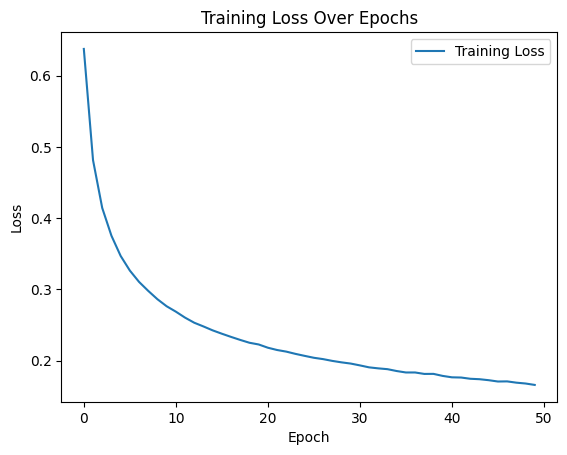

In [20]:
# Plot the loss over epochs
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Test Accuracy: 91.046%
Train Accuracy: 93.427%


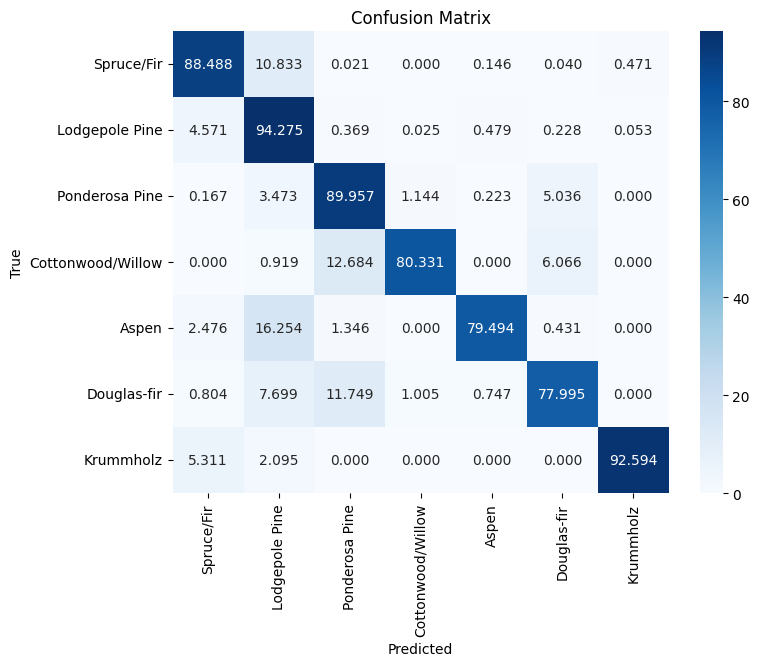

Classification Report:
                   precision    recall  f1-score   support

       Spruce/Fir       0.93      0.88      0.91     42452
   Lodgepole Pine       0.91      0.94      0.92     56594
   Ponderosa Pine       0.90      0.90      0.90      7169
Cottonwood/Willow       0.77      0.80      0.79       544
            Aspen       0.80      0.79      0.80      1858
      Douglas-fir       0.83      0.78      0.81      3481
        Krummholz       0.94      0.93      0.93      4105

         accuracy                           0.91    116203
        macro avg       0.87      0.86      0.86    116203
     weighted avg       0.91      0.91      0.91    116203



In [21]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor.unsqueeze(1))
    _, test_predicted = torch.max(test_outputs, 1)
    accuracy = (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    print(f"Test Accuracy: {accuracy * 100:.3f}%")

    train_outputs = model(X_train_tensor.unsqueeze(1))
    _, train_predicted = torch.max(train_outputs, 1)
    accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)

    print(f"Train Accuracy: {accuracy * 100:.3f}%")

    # Convert tensor predictions and ground truth to numpy arrays
    test_predicted_np = test_predicted.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_np, test_predicted_np)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Visualize the confusion matrix
    classes = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir',
                   'Krummholz']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".3f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Generate and print the classification report
    print("Classification Report:")
    print(classification_report(y_test_np, test_predicted_np, target_names=classes))

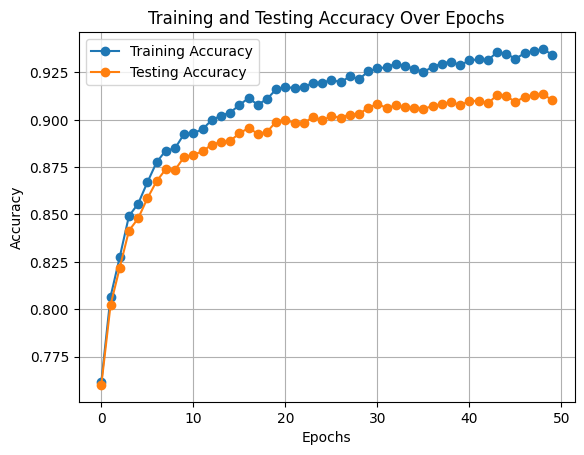

In [22]:
# Plot the accuracy for training and testing set over epochs
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(test_acc, label='Testing Accuracy', marker='o')

plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()